In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import MNIST

C:\Users\shdhk\anaconda3\envs\agent\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\shdhk\anaconda3\envs\agent\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
plt.style.use("ggplot")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
CHANNELS, IMG_ROWS, IMG_COLS = 1, 28, 28
IMG_SHAPE = (CHANNELS, IMG_ROWS, IMG_COLS)
Z_DIM = 100

In [3]:
class Generator(nn.Module):
    def __init__(self, img_shape, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 1 * 28 * 28)
        self.tanh = nn.Tanh()
        self.img_shape = img_shape

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.tanh(self.fc2(x))
        x = x.reshape(-1, *self.img_shape)
        return x


generator = Generator(img_shape=IMG_SHAPE, z_dim=Z_DIM).to(DEVICE)
summary(generator, (Z_DIM, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          12,928
            Linear-2                  [-1, 784]         101,136
              Tanh-3                  [-1, 784]               0
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = x.view(-1, 1 * 28 * 28)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        output = self.fc2(x)
        return output
    
    
discriminator = Discriminator().to(DEVICE)
summary(discriminator, IMG_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                    [-1, 1]             129
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [5]:
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.002)
optimizer_g = optim.Adam(generator.parameters(), lr=0.002)
criterion = nn.BCEWithLogitsLoss()

In [6]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_cols=4, path="./Chapter03_image"):
    if not os.path.exists(path):
        os.mkdir(path)
    z = torch.randn(image_grid_rows * image_grid_cols, Z_DIM).to(DEVICE)
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z)
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = gen_imgs.detach().to(torch.device("cpu")).numpy()
    fig, axes = plt.subplots(image_grid_rows, image_grid_cols, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axes[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap="gray")
            axes[i, j].axis("off")
            cnt += 1
    plt.tight_layout()
    plt.savefig(f"{path}/img_{iteration:03d}")
    plt.close()

In [7]:
losses, iteration_checkpoints = [], []
iterations = 20000
batch_size = 128
sample_interval = 1000

download_root = "./MNIST_DATASET"
train_dataset = MNIST(download_root, train=True, download=True)
train_img = (train_dataset.data / 127.5) - 1.0
train_img = torch.unsqueeze(train_img, 1)

real = torch.ones(batch_size, 1).to(DEVICE)
fake = torch.zeros(batch_size, 1).to(DEVICE)

for iteration in range(iterations):
    idx = np.random.randint(low=0, high=train_img.shape[0], size=batch_size)
    real_imgs = train_img[idx].to(DEVICE)

    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    gen_imgs = generator(z)

    optimizer_d.zero_grad()
    d_pred_real, d_pred_fake = discriminator(real_imgs), discriminator(gen_imgs)
    d_loss_real, d_loss_fake = criterion(d_pred_real, real), criterion(d_pred_fake, fake)
    d_loss = (d_loss_real + d_loss_fake) * 0.5
    d_loss.backward()
    optimizer_d.step()

    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    gen_imgs = generator(z)

    optimizer_g.zero_grad()
    d_pred_fake = discriminator(gen_imgs)
    g_loss = criterion(d_pred_fake, real)
    g_loss.backward()
    optimizer_g.step()

    if (iteration + 1) % sample_interval == 0:
        losses.append([d_loss.item(), g_loss.item()])
        iteration_checkpoints.append(iteration + 1)
        print(f"{iteration + 1} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        sample_images(generator, iteration=iteration + 1)

1000 [D loss: 0.0313] [G loss: 6.6698]
2000 [D loss: 0.1607] [G loss: 7.9827]
3000 [D loss: 0.9048] [G loss: 3.4637]
4000 [D loss: 0.7498] [G loss: 2.0711]
5000 [D loss: 1.2544] [G loss: 4.2282]
6000 [D loss: 0.2959] [G loss: 2.9016]
7000 [D loss: 0.6915] [G loss: 1.6878]
8000 [D loss: 0.3245] [G loss: 2.3518]
9000 [D loss: 0.4516] [G loss: 2.5420]
10000 [D loss: 0.9330] [G loss: 1.8050]
11000 [D loss: 0.6626] [G loss: 1.5280]
12000 [D loss: 0.7604] [G loss: 1.8741]
13000 [D loss: 0.4081] [G loss: 2.1926]
14000 [D loss: 0.3324] [G loss: 2.6040]
15000 [D loss: 0.4007] [G loss: 3.6081]
16000 [D loss: 0.6025] [G loss: 2.2720]
17000 [D loss: 0.4803] [G loss: 1.6251]
18000 [D loss: 0.5638] [G loss: 2.5856]
19000 [D loss: 0.6476] [G loss: 2.3660]
20000 [D loss: 0.3968] [G loss: 2.3722]


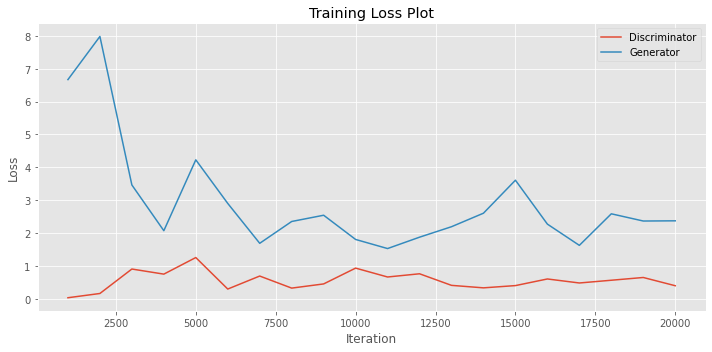

In [8]:
losses_np = np.array(losses)

plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(iteration_checkpoints, losses_np.T[0], label="Discriminator")
plt.plot(iteration_checkpoints, losses_np.T[1], label="Generator")
plt.title("Training Loss Plot")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc="best")